In [1]:
# 17 August 2021
# Experiment: ran featurecounts across all cells in RCMB56-ht (~5k), for each counting read coverage at 1000 
# randomly permuted 1Mb genomic regions.

In [2]:
import pandas as pd
import os
os.chdir('/mnt/c/Users/ochapman/Documents/Mesirov/scRNA+ATAC/2021-08-17_featurecounts-permutation-2')
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import math
from statsmodels.stats.multitest import multipletests 
from matplotlib_venn import *

import upsetplot

%matplotlib inline
pd.set_option('display.max_rows', 30)


In [3]:
def load_features(file,ecDNA):
    '''
    returns: series
    index: barcode
    '''
    df = pd.read_csv(file,sep='\t',index_col='barcode')
    # divide by length in megabases
    if ecDNA == 'ecDNA1':
        df = df.ecDNA1
        df //= 3.177119
    elif ecDNA == 'ecDNA2':
        df = df.ecDNA2
        df //= 4.455655
    elif ecDNA == 'ecDNA3':
        df = df.ecDNA3
        df //= 35.231882
    else:
        raise ValueError("Must be ecDNA1, 2 or 3")
    return df
def load_backgrounds(file):
    '''
    returns: dataframe
    rows: random permutation
    columns: barcode.bam
    access as df[barcode.bam]
    '''
    df = pd.read_csv(file,sep='\t',index_col='Geneid',skiprows=1)
    df = df.iloc[:,5:]
    df.columns = df.columns.map(lambda x: x.split('/')[-1])
    df.columns = df.columns.map(lambda x: x.split('.')[0])
    return df

In [17]:
def fit_poisson(observed,backgrounds):
    # Set up dataframe of observed featurecounts    
    df = pd.DataFrame(observed)
    df.columns=['Observed']
    
    # Estimate empirical p
    bg=backgrounds
    df['empirical p-val']=observed.index.map(lambda x: ((observed[x] <= bg[x]).sum()+1) / (len(bg[x])+1))
    
    # Fit to Poisson distribution
    mu = bg.mean()
    mu.name = 'mu'
    df = df.join(mu)
    
    # Generate p-values as 1-cdf
    df['poisson_pval'] = df.index.map(lambda x: scipy.stats.poisson.sf(k=df.loc[x,'Observed']-1,mu=df.loc[x,'mu']))
    
    # z-scores
    df['z-score'] = df.index.map(lambda x: (df.loc[x,'Observed'] - df.loc[x,'mu'])/math.sqrt(df.loc[x,'mu']))
    return df


In [10]:
def gen_histograms(observed,backgrounds,outfile_prefix):
    w=6
    h=6
    poisson = fit_poisson(observed,backgrounds)
    poisson = poisson.loc[backgrounds.columns]
    backgrounds=backgrounds.iloc[:,:w*h]
    fig,axes = plt.subplots(h,w, figsize=(20,20))
    for i in range(h*w):
        sns.histplot(ax=axes[i//h,i%h],data=backgrounds.iloc[:,i])
        # observed value
        axes[i//h,i%h].axvline(poisson.iloc[i,0],c='red')
        # z-score
        #sigma = 3*math.sqrt(poisson.iloc[i,2])
        #axes[i//h,i%h].axvline(sigma,c='blue')
        text = 'empirical p<'+str(round(poisson.iloc[i,1],3))+'\npoisson p~'+str(round(poisson.iloc[i,3],3))
        axes[i//h,i%h].text(0.9,0.8,text,horizontalalignment='right',transform=axes[i//h,i%h].transAxes)
    fig.savefig(outfile_prefix+'.svg')
    fig.savefig(outfile_prefix+'.png')

In [11]:
def classify(fgs,bg):
    df = fit_poisson(fgs[0],bg)['empirical p-val']
    e = multipletests(df,alpha=0.1,method='fdr_bh')
    classifications = pd.DataFrame(index=df.index,data=e[0],columns=['ecDNA1'])
    for i in range(len(fgs[1:])):
        df = fit_poisson(fgs[i+1],bg)['empirical p-val']
        e = multipletests(df,alpha=0.1,method='fdr_bh')
        colname='ecDNA'+str(i+2)
        classifications[colname] = e[0]
    return classifications


In [12]:
def summary_venn3(df,out_prefix):
    _000 = df[~df.ecDNA1 & ~df.ecDNA2 & ~df.ecDNA3]
    _001 = df[~df.ecDNA1 & ~df.ecDNA2 & df.ecDNA3]
    _010 = df[~df.ecDNA1 & df.ecDNA2 & ~df.ecDNA3]
    _100 = df[df.ecDNA1 & ~df.ecDNA2 & ~df.ecDNA3]
    _101 = df[df.ecDNA1 & ~df.ecDNA2 & df.ecDNA3]
    _110 = df[df.ecDNA1 & df.ecDNA2 & ~df.ecDNA3]
    _011 = df[~df.ecDNA1 & df.ecDNA2 & df.ecDNA3]
    _111 = df[df.ecDNA1 & df.ecDNA2 & df.ecDNA3]

    subsets = (len(_100),len(_010),len(_110),len(_001),len(_101),len(_011),len(_111),len(_000))
    plt.figure()
    venn3_unweighted(subsets[:-1],set_labels=['ecDNA1','ecDNA2','ecDNA3'],alpha=0.5)
    plt.savefig(out_prefix+' venn.svg')
    plt.savefig(out_prefix+' venn.png')

def summary_venn2(df,out_prefix):
    plt.figure()
    _00 = df[~df.ecDNA1 & ~df.ecDNA2]
    _01 = df[~df.ecDNA1 & df.ecDNA2]
    _10 = df[df.ecDNA1 & ~df.ecDNA2]
    _11 = df[df.ecDNA1 & df.ecDNA2]
    subsets = (len(_10),len(_01),len(_11),len(_00))
    print(subsets)
    venn2(subsets[:-1],set_labels=['ecDNA1','ecDNA2'],alpha=0.5)
    plt.savefig(out_prefix+' venn.svg')
    plt.savefig(out_prefix+' venn.png')
    
def plot_upset(df,out_prefix):
    # data = upsetplot.from_indicators(df) # from_indicators is bugged, hardcode for now.
    _000 = df[~df.ecDNA1 & ~df.ecDNA2 & ~df.ecDNA3]
    _001 = df[~df.ecDNA1 & ~df.ecDNA2 & df.ecDNA3]
    _010 = df[~df.ecDNA1 & df.ecDNA2 & ~df.ecDNA3]
    _100 = df[df.ecDNA1 & ~df.ecDNA2 & ~df.ecDNA3]
    _101 = df[df.ecDNA1 & ~df.ecDNA2 & df.ecDNA3]
    _110 = df[df.ecDNA1 & df.ecDNA2 & ~df.ecDNA3]
    _011 = df[~df.ecDNA1 & df.ecDNA2 & df.ecDNA3]
    _111 = df[df.ecDNA1 & df.ecDNA2 & df.ecDNA3]
    data = upsetplot.from_memberships(
        [[],
         ['ecDNA1'],
         ['ecDNA2'],
         ['ecDNA3'],
         ['ecDNA1','ecDNA2'],
         ['ecDNA1','ecDNA3'],
         ['ecDNA2','ecDNA3'],
         ['ecDNA1','ecDNA2','ecDNA3']
        ],
        data=[len(_000),len(_100),len(_010),len(_001),len(_110),len(_101),len(_011),len(_111)]
    )
    plt.figure()
    upsetplot.plot(data)
    plt.savefig(out_prefix+' upset.svg')
    plt.savefig(out_prefix+' upset.png')
    return data

In [13]:
def parse_featurecounts_to_series(file):
    assert file.endswith(".summary")
    with open(file,'r') as f:
        index = f.readline().strip().split()[1:]
        index = map(lambda x: x.split('/')[-1],index)
        index = map(lambda x: x.split('.')[0],index)
        values = f.readline().strip().split()[1:]
        values = map(int,values)
        return pd.Series(data=values,index=index)

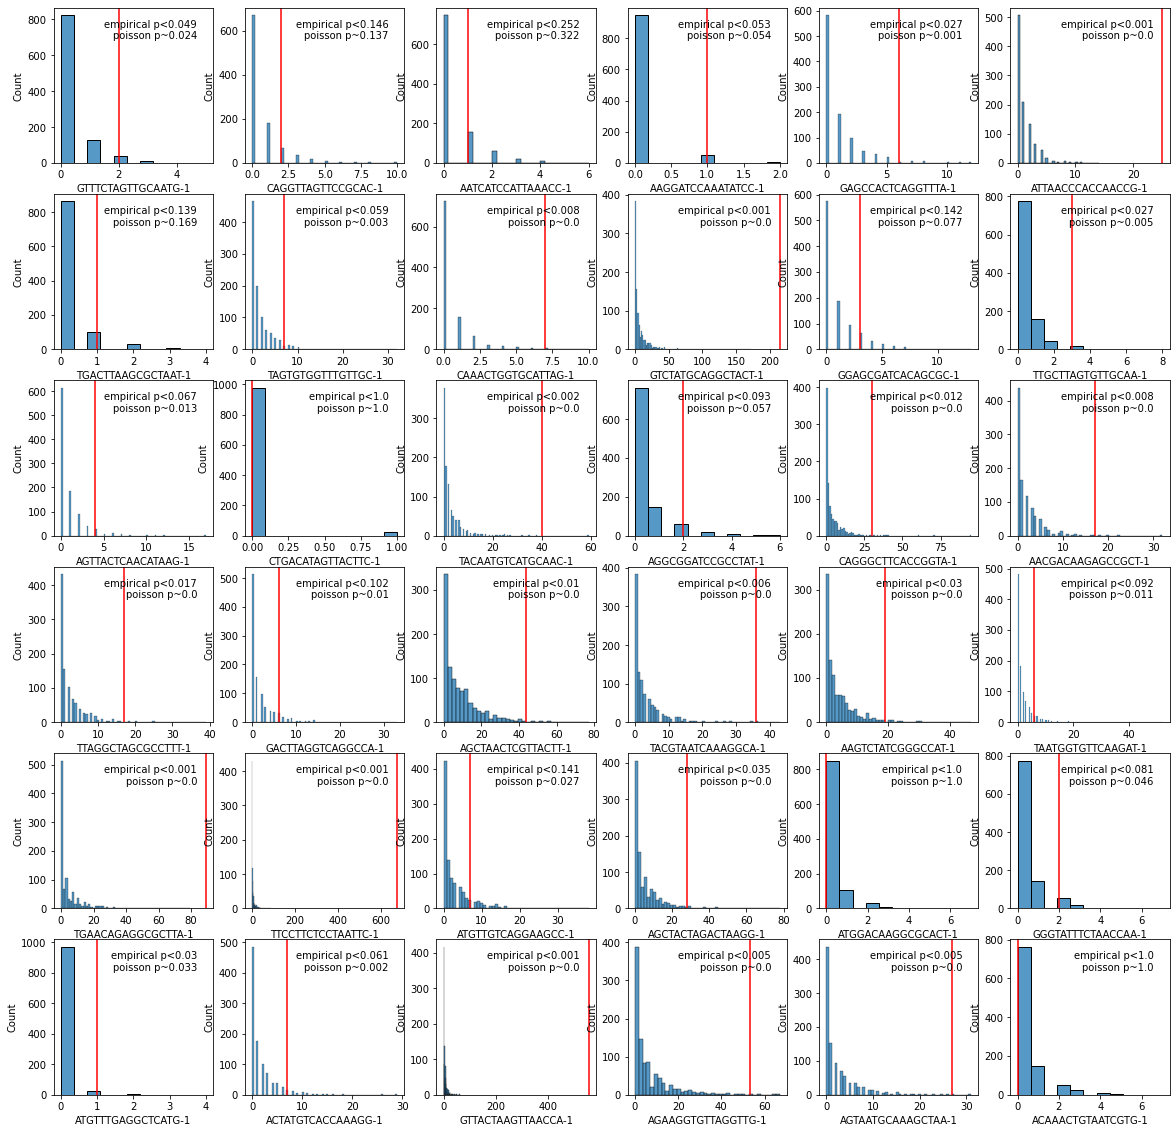

<Figure size 432x288 with 0 Axes>

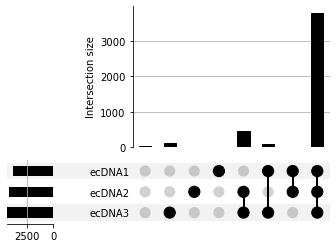

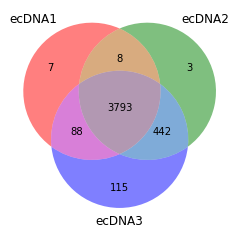

In [21]:
# Run RCMB56-ht
#fg1 = load_features('RCMB56-ht.tsv','ecDNA1')
fg1 = parse_featurecounts_to_series('inputs/ht_case11_ecDNA_1_counts.txt.summary')
bg = load_backgrounds('featurecounts-permutations-ht.tsv')
#df = fit_poisson(fg1,bg)
gen_histograms(fg1,bg,'single cell ecDNA detection RCMB56-ht ecDNA1')
#fg2 = load_features('RCMB56-ht.tsv','ecDNA2')
fg2 = parse_featurecounts_to_series('inputs/ht_case11_ecDNA_2_counts.txt.summary')
fg3 = parse_featurecounts_to_series('inputs/ht_RCMB56_ecDNA_3_counts.txt.summary')
#fg3 = load_features('RCMB56-ht.tsv','ecDNA3')
df = classify([fg1,fg2,fg3],bg)
df.to_csv('RCMB56-ht_cell-classifications.tsv',sep='\t')
plot_upset(df,'RCMB56-ht')
summary_venn3(df,'RCMB56-ht')
df1 = fit_poisson(fg1,bg)
df1.to_csv("RCMB56-ht_ecDNA1_poisson.tsv",sep='\t')
df2 = fit_poisson(fg2,bg)
df2.to_csv("RCMB56-ht_ecDNA2_poisson.tsv",sep='\t')
df3 = fit_poisson(fg3,bg)
df3.to_csv("RCMB56-ht_ecDNA3_poisson.tsv",sep='\t')

In [18]:
df1 = fit_poisson(fg1,bg)
df1.to_csv("RCMB56-pdx_ecDNA1_poisson.tsv",sep='\t')
df2 = fit_poisson(fg2,bg)
df2.to_csv("RCMB56-pdx_ecDNA2_poisson.tsv",sep='\t')
df3 = fit_poisson(fg3,bg)
df3.to_csv("RCMB56-pdx_ecDNA3_poisson.tsv",sep='\t')


,Observed,empirical p-val,mu,poisson_pval,z-score
AAACAGCCACTTCACT-1,16,0.000999,0.403,1.583601e-20,24.569060
AAACAGCCAGCCAGAA-1,127,0.000999,1.976,1.716253e-177,88.940572
AAACAGCCAGCTCATA-1,4,0.011988,0.455,1.244462e-03,5.255458
AAACAGCCAGGTTACC-1,24,0.000999,0.236,1.145003e-39,48.917420
AAACAGCCATGTCAAT-1,601,0.000999,4.002,0.000000e+00,298.424403
...,...,...,...,...,...
TTTGTTGGTGCCGCAA-1,144,0.000999,1.472,6.303159e-227,117.475225
TTTGTTGGTTACGCAA-1,9,0.000999,0.420,7.684872e-10,13.239227
TTTGTTGGTTAGCGTA-1,104,0.000999,1.863,1.940993e-139,74.830159
TTTGTTGGTTATCGAG-1,29,0.000999,2.713,3.064030e-20,15.959384


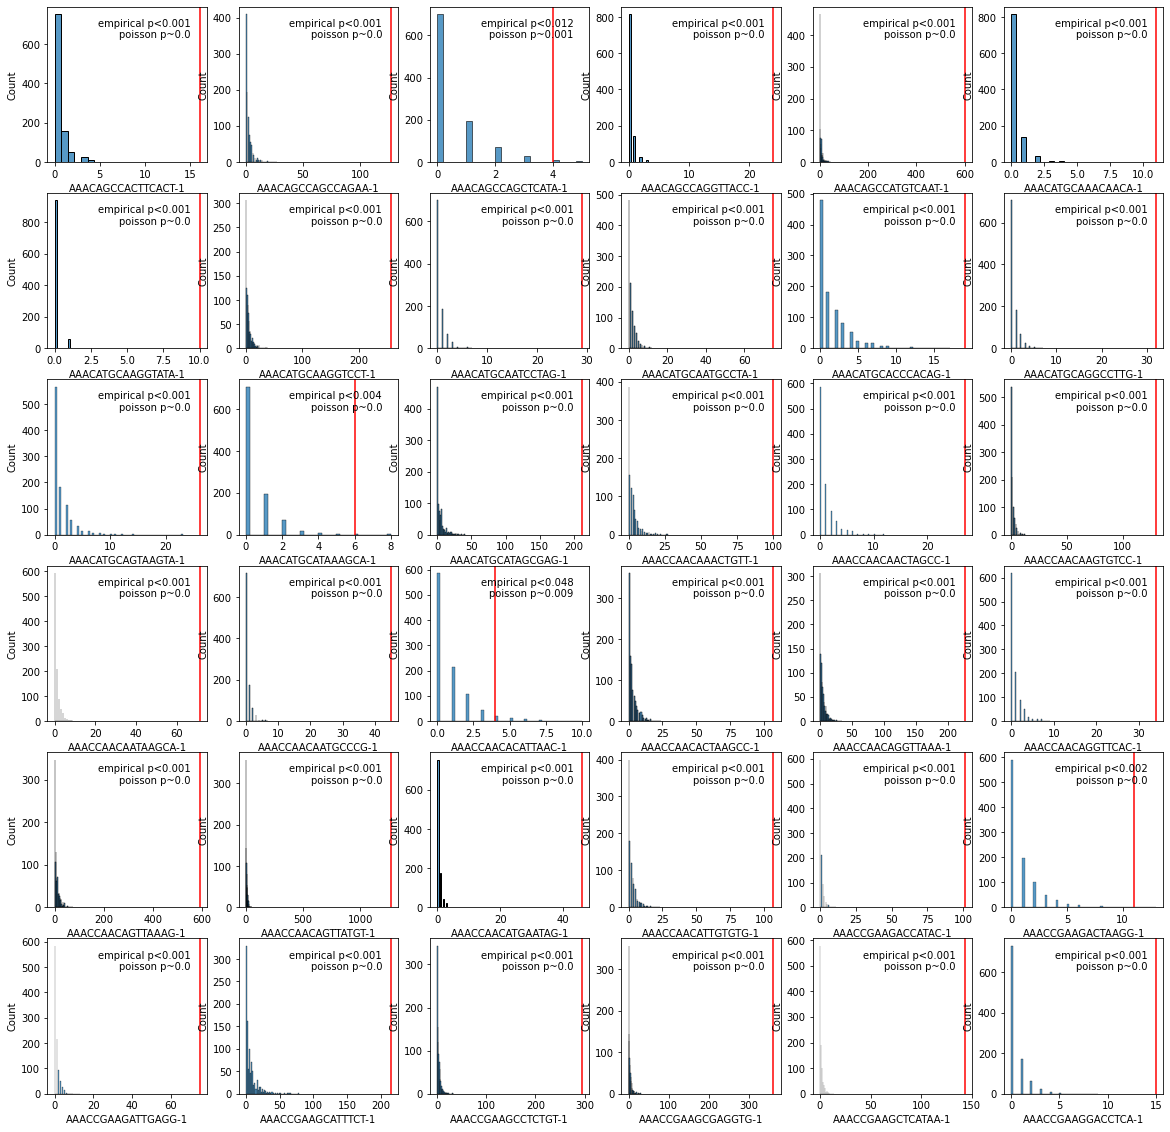

<Figure size 432x288 with 0 Axes>

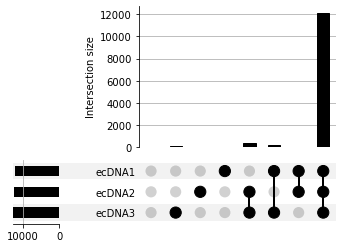

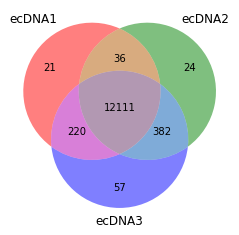

In [20]:
# Run RCMB56-pdx
fg1 = parse_featurecounts_to_series('inputs/RCMB56-pdx_case11_ecDNA_1_counts.txt.summary')
bg = load_backgrounds('featurecounts-permutations-pdx.tsv')
#df = fit_poisson(fg1,bg)
gen_histograms(fg1,bg,'single cell ecDNA detection RCMB56-ht ecDNA1')
fg2 = parse_featurecounts_to_series('inputs/RCMB56-pdx_case11_ecDNA_2_counts.txt.summary')
fg3 = parse_featurecounts_to_series('inputs/RCMB56-pdx_RCMB56_ecDNA_3_counts.txt.summary')
df = classify([fg1,fg2,fg3],bg)
df.to_csv('RCMB56-pdx_cell-classifications.tsv',sep='\t')
#summary_venn2(df,'RCMB56-pdx')
plot_upset(df,'RCMB56-pdx')
summary_venn3(df,'RCMB56-pdx')
df1 = fit_poisson(fg1,bg)
df1.to_csv("RCMB56-pdx_ecDNA1_poisson.tsv",sep='\t')
df2 = fit_poisson(fg2,bg)
df2.to_csv("RCMB56-pdx_ecDNA2_poisson.tsv",sep='\t')
df3 = fit_poisson(fg3,bg)
df3.to_csv("RCMB56-pdx_ecDNA3_poisson.tsv",sep='\t')

In [28]:
df

,ecDNA1,ecDNA2,ecDNA3
AAACAGCCACTTCACT-1,True,True,True
AAACAGCCAGCCAGAA-1,True,True,True
AAACAGCCAGCTCATA-1,True,True,True
AAACAGCCAGGTTACC-1,True,True,True
AAACAGCCATGTCAAT-1,True,True,True
...,...,...,...
TTTGTTGGTGCCGCAA-1,True,True,True
TTTGTTGGTTACGCAA-1,True,True,True
TTTGTTGGTTAGCGTA-1,True,True,True
TTTGTTGGTTATCGAG-1,True,True,True
